# Демо очистки артефактов в данных ЭЭГ
С использованием видео и без.

Импортируем реализованные модули работы с ЭЭГ и видео

In [5]:
import eeg.filtering
import eeg.io

import video.mediapipe1

Возьмем в качестве примера одну из записей испытуемых, файлы ЭЭГ и видео.

(Подставить требуемый путь файла в код ниже)

In [4]:
video_file_path = r"C:\Projects\Panga\eeg-artifact-filtering\data\ANMR002.mp4"
eeg_filepath = (
    r"C:\Projects\Panga\eeg-artifact-filtering\data\2024.01.17-13.45.38.269.edf"
)

Для выявления временных меток возможных артефактов из видео файла используем модуль `video`.

Сначала создается виджет `VideoStreamWidget` для анализа видео, в который передаются параметры:
- `src: str` - путь к файлу с видео
- `live: bool` - показывать ли видео вживую в процессе анализа. Для скорости обработки рекомендуется передавать `False`.
- `save_data: bool` - сохранить ли проанализированные данные в файл. Сохранение будет произведено в CSV файл в той же папке, что и запускаемый скрипт.

Для анализа видео выполняется метод `run()` виджета, после чего в атрибуте виджета `final_data` будет сохранен список словарей с временными метками и распознанными в этом моменте видео действиями человека, с вероятностью распознания каждого действия.

По умолчанию в результат попадают только действия с вероятностью > 0.2.

In [7]:
video_stream_widget = video.mediapipe1.VideoStreamWidget(
    src=video_file_path, live=False, save_data=True
)
video_stream_widget.run()
artifact_data = video_stream_widget.final_data

'VideoStreamWidget' object has no attribute 'frame'
'VideoStreamWidget' object has no attribute 'frame'
'VideoStreamWidget' object has no attribute 'frame'
'VideoStreamWidget' object has no attribute 'frame'
'VideoStreamWidget' object has no attribute 'frame'
'VideoStreamWidget' object has no attribute 'frame'
'VideoStreamWidget' object has no attribute 'frame'
'VideoStreamWidget' object has no attribute 'frame'
'VideoStreamWidget' object has no attribute 'frame'
'VideoStreamWidget' object has no attribute 'frame'
'VideoStreamWidget' object has no attribute 'frame'
'VideoStreamWidget' object has no attribute 'frame'
'VideoStreamWidget' object has no attribute 'frame'
'VideoStreamWidget' object has no attribute 'frame'
'VideoStreamWidget' object has no attribute 'frame'
'VideoStreamWidget' object has no attribute 'frame'
'VideoStreamWidget' object has no attribute 'frame'
'VideoStreamWidget' object has no attribute 'frame'
'VideoStreamWidget' object has no attribute 'frame'
'VideoStream

Далее данные анализа видео преобразуются в формат "интервалов артефактов", считываемый модулем фильтрации ЭЭГ.

При этом для каждой временной метки производятся следующие операции:
- Действие с наибольшей вероятностью выбирается в качестве основного.
- Создается интервал с началом и концом выбранного действия (например, +/- 0.25 сек).

Может быть реализована кастомная логика преобразования.
- Как вариант, можно отбирать для временной метки все действия с вероятностью > N, для каждого из них создать интервал требуемой длительности.
- Примеры:
    - Интервал для моргания - 0.2 секунды, со сдвигом на 0.3 секунды позже временной метки.
    - Интервал для поворота головой - 0.5 секунд, с началом и концом интервала -0.25 и +0.25 секунд от временной метки.

Пример данных требуемого формата описан ниже:
```python
[
    (1.0, 1.5, "HEAD_LEFT"),
    (1.6, 1.8, "HEAD_LEFT"),
    (5.2, 6.4, "STAND"),
    (9.1, 9.4, "BLINK"),
]
```

In [8]:
# Make timestamps from video into intervals
artifact_intervals = []
for item in artifact_data:
    actions: dict = item["actions"]
    likeliest_action_name = max(actions, key=actions.get)

    ts = item["ts"]
    start = ts - 0.25
    stop = ts + 0.25
    
    artifact_intervals.append((start, stop, likeliest_action_name))

Далее читается файл с данными ЭЭГ и трансформируется в формат DataFrame (библиотеки pandas) для дальнейшей очистки.

При трансформации в DataFrame данные записаны в микровольтах для каналов ЭЭГ.

Микровольтные значения ЭЭГ каналов делятся на 1 000 000, чтобы в дальнейшем корректно сформировать объекта `mne.Raw` библиотеки `mne`, т.к. он принимает на вход значения в вольтах. 

In [14]:
raw_eeg = eeg.io.read_edf_file(eeg_filepath)
# .to_data_frame returns in microvolts
raw_eeg_df = raw_eeg.to_data_frame()
# need to convert microvolts data to volts to form correct mne Raw object later
raw_eeg_df.loc[:, raw_eeg_df.columns != "time"] = (
    raw_eeg_df.loc[:, raw_eeg_df.columns != "time"] / 1e6
)

Extracting EDF parameters from C:\Projects\Panga\eeg-artifact-filtering\data\2024.01.17-13.45.38.269.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 97249  =      0.000 ...   777.992 secs...


Данные ЭЭГ очищаются с помощью функции `clean_eeg()` модуля `eeg.filtering`. У этого метода есть ряд параметров, которые позволяют гибко настроить требуемую логику очистки.

Метод принимает на вход следующие параметры:
- `raw_eeg_df`: DataFrame с данными ЭЭГ для очистки. Должен содержать столбцы, названные каналами ЭЭГ, со значениями вольтажа этих каналов для каждого датапоинта.
- `sample_freq`: Частота сэмплирования данных с нейроинтерфейса (например, 125 Гц для Neuroplay). Можно получить это значение из объекта ЭЭГ данных `mne.Raw`.
- `artifact_intervals`: Интервалы артефактов с секундами начала/окончания и артефактным действием.
    Используется для детальной поканальной очистки.
    Пример приведен выше.
- `method`: Метод очистки ЭЭГ - "iterative" или "fft".
    "fft" - чистка по частотам с помощью преобразования Фурье.
    "iterative" - вырезаются артефактные значения, множественная импутация воссоздает реальные значения. Эксспериментально, т.к. качественное предсказание еще занимает большое количество времени.
    По умолчанию - "fft".
- `artifact_specs`: Словарь очищаемых каналов и частот по каждому артефакту.
    Частоты задаются списком кортежей `(freq1, freq2)`.
        Если the `freq1` < `freq2`, будут очищены все частоты в интервалы.
        Если the `freq1` == `freq2`, очищается только выбранная частота.
        Если `freq1` имеет значение `None`, очищаются все частоты меньше или равные `freq2`.
        Если `freq2` имеет значение `None`, очищаются все частоты больше или равные `freq1`.
        Если `freq1` и `freq2` имеют значение `None`, очищаются абсолютно все частоты.
        Если не требуется очищать ничего для конкретного артефакта, нужно задать ему значение пустого списка `[]`.
    Значение по умолчанию можно найти в модуле `eeg.default` в переменной `DEFAULT_ACTION_ARTIFACT_FREQS`.
    Пример:
    ```json
    {
        "HEAD_LEFT": {"Fp1": [(0.1, 8)], "Fp2": [(0.1, 8)]},
        "STAND": {"O1": [(0.1, 8)], "T3": [(0.1, 8)]},
        "BLINK": {"O1": [(0.1, 8)], "O2": [(0.1, 8)]}
    }
    ```
- `total_clean_freqs`: Частоты для очистки со всех каналов.
    Такой же формат, как для артефакта в `artifact_specs`.
    По умолчанию - `[(0.1, 8)]`.
    Пример: `[(0.1, 8), (50, 50)]`.
- `total_clean_coef`: Коэффициент, на который умножаются частоты для их очистки.
    По умолчанию - `0.001`.

In [15]:
cleaned_eeg = eeg.filtering.clean_eeg(
    raw_eeg_df,
    raw_eeg.info["sfreq"],
    artifact_intervals,
    method="fft",
)

Далее из очищенных данных ЭЭГ и данных Info сырых данных формируется новый объект `mne.Raw` и сохраняется в EDF-файл `cleaned_eeg.edf` в той же папке, что и запускаемый скрипт.

In [16]:
cleaned_eeg = eeg.filtering.make_mne_raw(cleaned_eeg.values, raw_eeg.info)
cleaned_eeg_filepath = "cleaned_eeg.edf"
eeg.io.write_edf_file(cleaned_eeg, cleaned_eeg_filepath)

Creating RawArray with float64 data, n_channels=6, n_times=97250
    Range : 0 ... 97249 =      0.000 ...   777.992 secs
Ready.
Overwriting existing file.


Ниже описан пример визуализации ЭЭГ данных, по которому можно посмотреть данные до и после очистки.

Рекомендуется запускать эту визуализацию не в Jupyter Notebook, а в скрипте с режимом дебага. В таком случае можно поставить точку остановки (breakpoint) на команду `print()` после команд формирования визуализации, что позволит посмотреть оба графики бок о бок в интерактивном режиме (можно включать, выключать каналы, изменять масштаб). 

Extracting EDF parameters from C:\Projects\Panga\eeg-artifact-filtering\data\2024.01.17-13.45.38.269.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 97249  =      0.000 ...   777.992 secs...
Extracting EDF parameters from c:\Projects\Panga\eeg-artifact-filtering\src\cleaned_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 97249  =      0.000 ...   777.992 secs...
Using matplotlib as 2D backend.


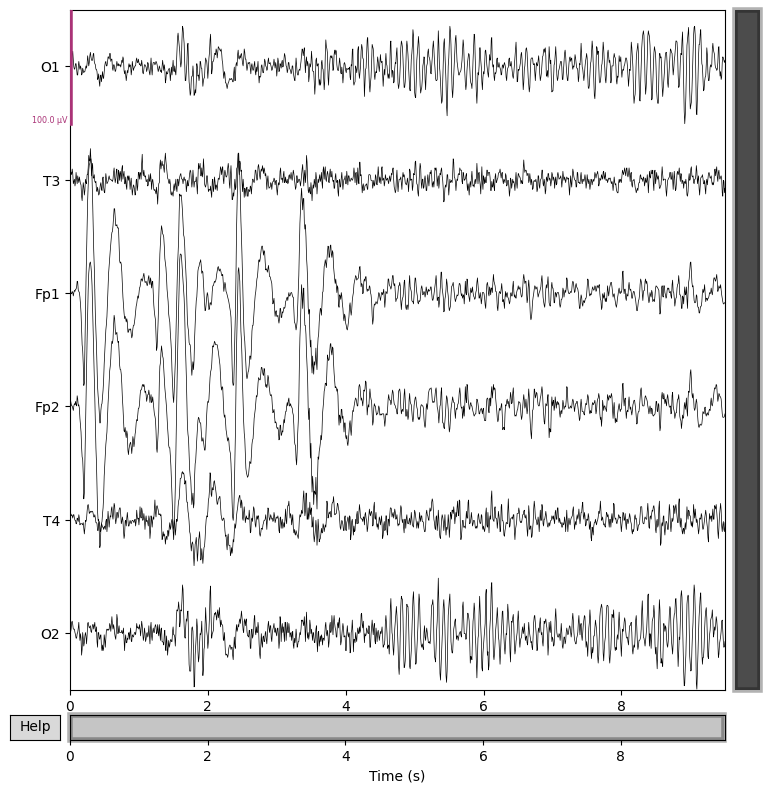

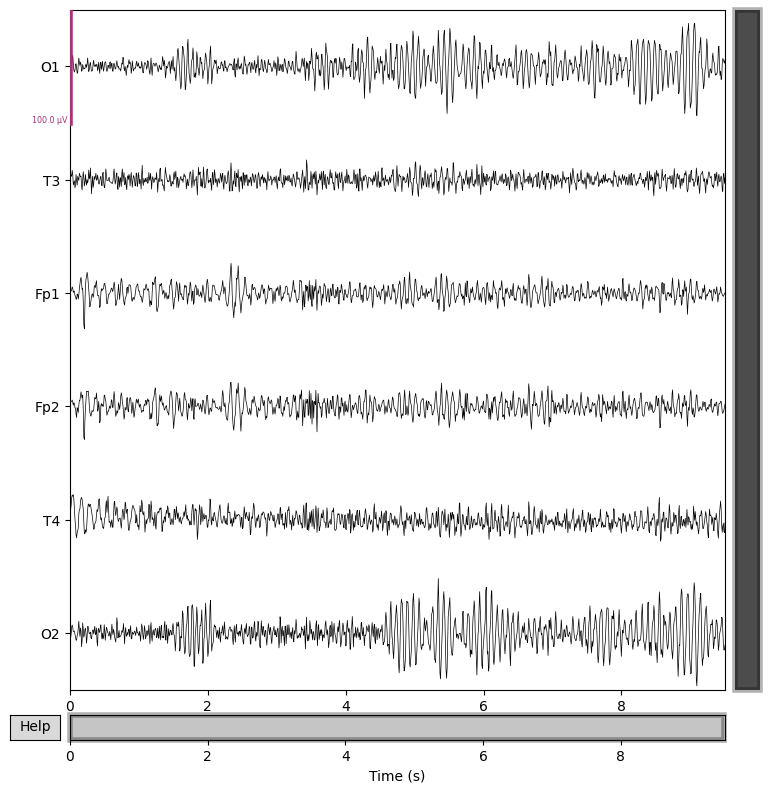

In [17]:
## Visualization
rw = eeg.io.read_edf_file(eeg_filepath)
cln = eeg.io.read_edf_file(cleaned_eeg_filepath)
rw.crop(tmin=0.5, tmax=10).plot(
    n_channels=6,
    scalings=0.00005,
    title="Before artifact removal",
)
cln.crop(tmin=0.5, tmax=10).plot(
    n_channels=6,
    scalings=0.00005,
    title="After artifact removal",
)

print()